# Summary of Inter GPU Point-to-Point Communication between Two Nodes

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('display.max_columns', 20)


project_dir = Path(os.getcwd()).parents[0]
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    pattern = '# Size'
    in_data = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if not in_data:
                if line.startswith(pattern):
                    in_data = True
                    continue
            else:
                lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data(metrics):
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    mem_types = {
        'host': 'prc',
        'gpu': 'gpu'
    }
    procs = [1, 4, 8]

    series = []
    for mem, suffix in mem_types.items():
        for node, dirpath in node_types.items():
            for proc in procs:
                column_key = f'{mem}:{node}:{proc}'
                file_pattern = f'{dirpath}/job{proc:02d}.sh.*.{suffix}.{metrics}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, ylabel):
    def _xticks_labels():
        idxs = [2, 6, 10, 14, 18, 22]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel(ylabel)
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)
    
def plot_bandwidth(data, column_labels, markers, title):
    plot(data, column_labels, markers, title, 'Bandwidth (MB/s)')

def plot_latency(data, column_labels, markers, title):
    plot(data, column_labels, markers, title, 'Time (Micro-second)')

## Bandwidth

In [3]:
bw_data = load_data('bandwidth')
bw_data

,host:anode:1,host:anode:4,host:anode:8,host:vnode:1,host:vnode:4,gpu:anode:1,gpu:anode:4,gpu:anode:8,gpu:vnode:1,gpu:vnode:4
1,5.59,19.32,44.02,5.36,20.65,3.10,11.96,21.84,2.45,9.60
2,11.28,44.67,89.18,11.00,41.77,6.24,23.80,43.69,5.08,18.65
4,22.58,89.41,177.35,21.84,83.16,10.87,48.19,87.19,10.19,37.11
8,45.23,176.45,356.08,44.09,166.74,21.85,95.62,174.87,12.06,74.43
16,90.39,351.00,710.81,89.64,338.72,49.91,191.93,350.28,41.32,148.70
32,180.01,713.27,1417.52,176.79,667.23,99.87,383.88,700.07,80.73,312.50
64,347.78,1378.91,2680.80,319.91,1238.69,138.54,629.68,1306.00,101.69,607.71
128,675.27,2646.58,5142.08,635.44,2477.78,376.66,1443.41,2902.39,317.12,1208.80
256,1054.60,4140.64,8225.35,1127.80,4229.99,705.21,2741.87,5572.49,625.13,2124.49
512,1975.85,7946.04,15454.59,1981.60,7381.14,1166.49,5212.47,10259.98,989.05,2583.35


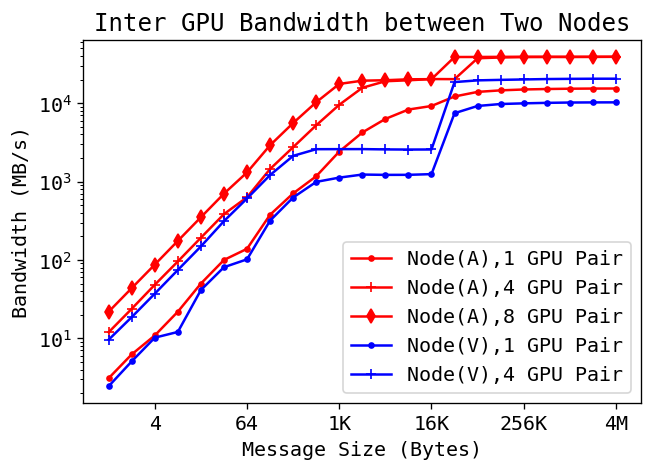

In [4]:
title = 'Inter GPU Bandwidth between Two Nodes'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.-', 'b+-']
plot_bandwidth(bw_data, column_labels, markers, title)

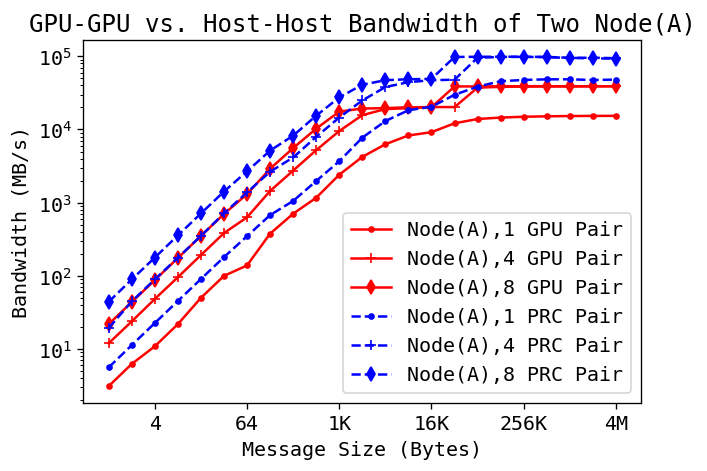

In [5]:
title = 'GPU-GPU vs. Host-Host Bandwidth of Two Node(A)'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'host:anode:1': 'Node(A),1 PRC Pair',
    'host:anode:4': 'Node(A),4 PRC Pair',
    'host:anode:8': 'Node(A),8 PRC Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.--', 'b+--', 'bd--']
plot_bandwidth(bw_data, column_labels, markers, title)

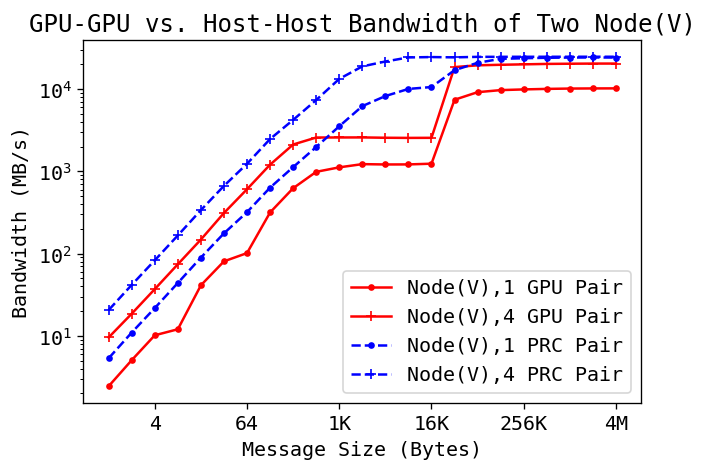

In [6]:
title = 'GPU-GPU vs. Host-Host Bandwidth of Two Node(V)'
column_labels = {
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
    'host:vnode:1': 'Node(V),1 PRC Pair',
    'host:vnode:4': 'Node(V),4 PRC Pair',
}
markers = ['r.-', 'r+-', 'b.--', 'b+--']
plot_bandwidth(bw_data, column_labels, markers, title)

# Latency

In [7]:
lat_data = load_data('latency')
lat_data

,host:anode:1,host:anode:4,host:anode:8,host:vnode:1,host:vnode:4,gpu:anode:1,gpu:anode:4,gpu:anode:8,gpu:vnode:1,gpu:vnode:4
0,1.19,1.37,1.38,0.87,0.98,1.83,2.07,2.12,1.28,1.42
1,1.19,1.35,1.35,0.86,0.89,2.99,3.38,3.91,2.68,2.66
2,1.19,1.35,1.34,0.86,0.88,3.02,3.22,3.27,2.37,2.47
4,1.19,1.35,1.35,0.86,0.89,2.99,3.22,3.28,2.37,2.47
8,1.19,1.35,1.34,0.86,0.89,2.99,3.21,3.29,2.38,2.48
16,1.19,1.35,1.35,0.86,0.90,2.99,3.22,3.28,2.40,2.48
32,1.22,1.37,1.37,0.92,0.94,3.04,3.50,3.95,2.42,2.61
64,1.29,1.44,1.44,1.03,1.06,3.16,3.53,4.06,2.53,2.72
128,1.32,1.48,1.48,1.06,1.09,3.13,3.52,4.02,2.56,2.74
256,1.60,1.76,1.76,1.52,1.58,3.22,3.56,4.10,2.63,2.80


In [8]:
lat_data = lat_data.drop(0, axis=0)

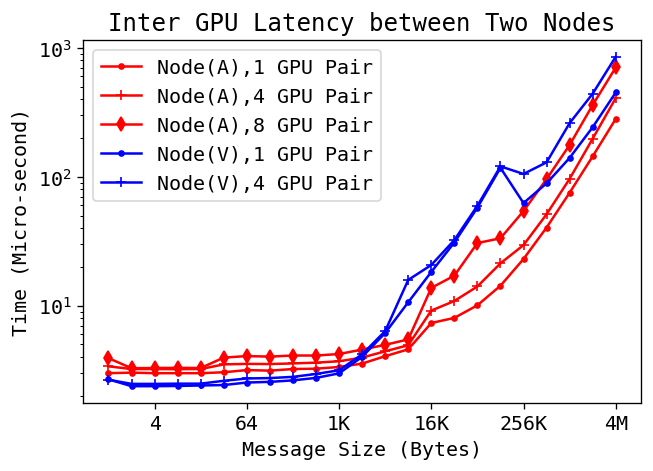

In [9]:
title = 'Inter GPU Latency between Two Nodes'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.-', 'b+-']
plot_latency(lat_data, column_labels, markers, title)

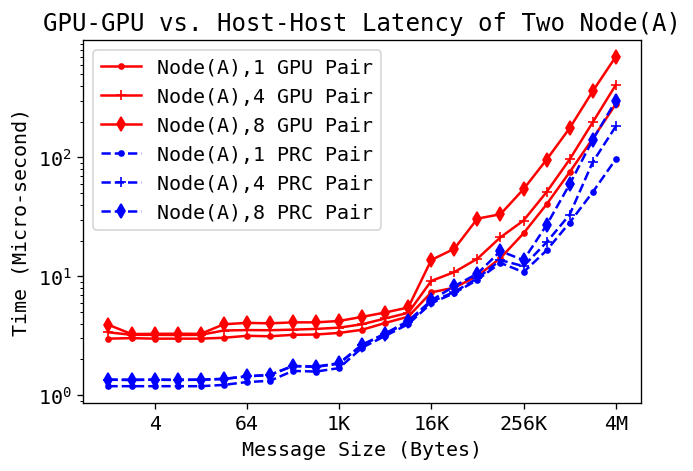

In [10]:
title = 'GPU-GPU vs. Host-Host Latency of Two Node(A)'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'host:anode:1': 'Node(A),1 PRC Pair',
    'host:anode:4': 'Node(A),4 PRC Pair',
    'host:anode:8': 'Node(A),8 PRC Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.--', 'b+--', 'bd--']
plot_latency(lat_data, column_labels, markers, title)

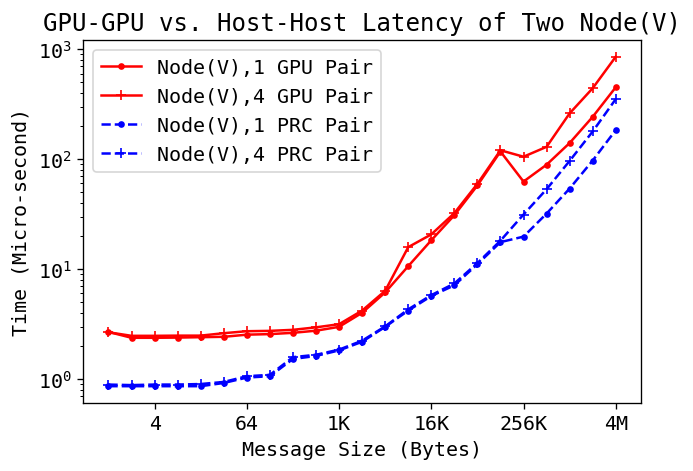

In [11]:
title = 'GPU-GPU vs. Host-Host Latency of Two Node(V)'
column_labels = {
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
    'host:vnode:1': 'Node(V),1 PRC Pair',
    'host:vnode:4': 'Node(V),4 PRC Pair',
}
markers = ['r.-', 'r+-', 'b.--', 'b+--']
plot_latency(lat_data, column_labels, markers, title)